In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import signal, interpolate, stats
import matplotlib.pyplot as plt

In [2]:
def load(file):
    frame = pd.read_csv(file, parse_dates=["Time"])
    frame = frame.set_index("Time")
    return frame

In [3]:
ircel = load("HungaTonga_Irceline.csv")
bme280 = load("HungaTonga_BM280.csv")

In [4]:
bme_1h = bme280.resample("1h").mean()

In [5]:
comp = pd.concat([ircel, bme_1h], axis=1).dropna(subset=["BME280"])
comp

,41R001,BME280
Time,,
2022-01-14 00:00:00,1037,1035.757382
2022-01-14 01:00:00,1037,1035.199718
2022-01-14 02:00:00,1036,1034.760167
2022-01-14 03:00:00,1036,1034.508078
2022-01-14 04:00:00,1036,1034.203889
...,...,...
2022-01-17 19:00:00,1036,1034.212535
2022-01-17 20:00:00,1036,1034.603064
2022-01-17 21:00:00,1037,1035.114763


In [6]:
credits = "Sources: Irceline, BlueBox\nCredits: J. Landercy"
credits2 = "Sources: BlueBox\nCredits: J. Landercy"

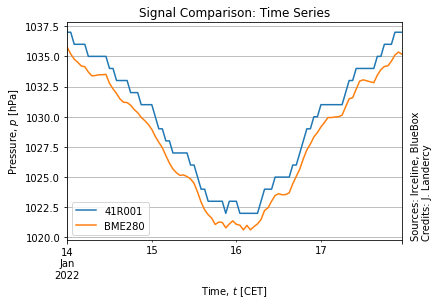

In [7]:
axe = comp.plot()
axe.set_title("Signal Comparison: Time Series")
axe.set_xlabel("Time, $t$ [CET]")
axe.set_ylabel("Pressure, $p$ [hPa]")
axe.figure.text(0.92, 0.13, credits, rotation=90)
axe.grid()

In [8]:
X = comp["41R001"].values.reshape(-1, 1)
y = comp["BME280"].values

In [9]:
reg = LinearRegression().fit(X, y)
score = reg.score(X, y)
score

0.9960983966777726

In [10]:
reg.coef_

array([0.99341705])

In [11]:
reg.intercept_

5.336835265946888

$\Delta p = \rho g h$

In [12]:
(reg.intercept_*100)/(1.225*9.81)

44.40978814576453

In [13]:
yhat = reg.predict(X)

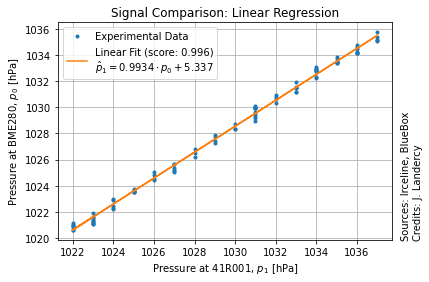

In [14]:
fig, axe = plt.subplots()
axe.plot(X, y, ".", label="Experimental Data")
axe.plot(X, yhat, label="Linear Fit (score: %.3f)\n$\hat{p}_1 = %.4f\cdot p_0 + %.3f$" % (score, reg.coef_[0], reg.intercept_))
axe.set_title("Signal Comparison: Linear Regression")
axe.set_xlabel("Pressure at 41R001, $p_1$ [hPa]")
axe.set_ylabel("Pressure at BME280, $p_0$ [hPa]")
axe.figure.text(0.92, 0.13, credits, rotation=90)
axe.legend()
axe.grid()

In [15]:
bme280

,BME280
Time,
2022-01-14 00:00:00,1036.0
2022-01-14 00:00:10,1036.0
2022-01-14 00:00:20,1036.0
2022-01-14 00:00:30,1036.0
2022-01-14 00:00:40,1036.0
...,...
2022-01-17 23:59:10,1035.2
2022-01-17 23:59:20,1035.2
2022-01-17 23:59:30,1035.2


In [16]:
bme280["Interpolated"] = bme280["BME280"].interpolate()
bme280["Baseline"] = signal.savgol_filter(bme280["Interpolated"].values, 121, 7)
bme280["Error"] = bme280["Interpolated"] - bme280["Baseline"]

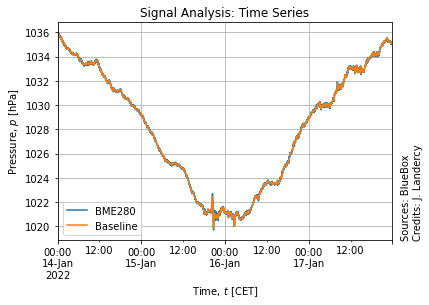

In [17]:
axe = bme280.loc[:,["BME280", "Baseline"]].plot()
axe.set_title("Signal Analysis: Time Series")
axe.set_xlabel("Time, $t$ [CET]")
axe.set_ylabel("Pressure, $p$ [hPa]")
axe.figure.text(0.92, 0.13, credits2, rotation=90)
axe.grid()

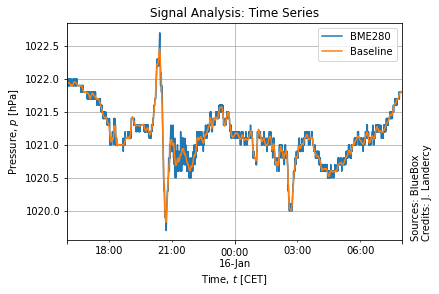

In [18]:
axe = bme280.loc["2022-01-15 16:00:00":"2022-01-16 08:00:00",["BME280", "Baseline"]].plot()
axe.set_title("Signal Analysis: Time Series")
axe.set_xlabel("Time, $t$ [CET]")
axe.set_ylabel("Pressure, $p$ [hPa]")
axe.figure.text(0.92, 0.13, credits2, rotation=90)
axe.grid()

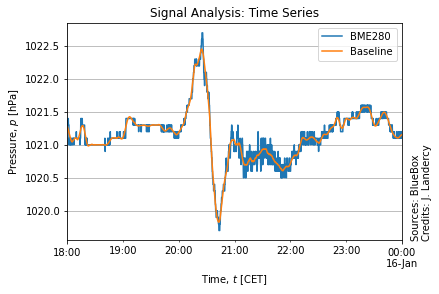

In [19]:
axe = bme280.loc["2022-01-15 18:00:00":"2022-01-16 00:00:00",["BME280", "Baseline"]].plot()
axe.set_title("Signal Analysis: Time Series")
axe.set_xlabel("Time, $t$ [CET]")
axe.set_ylabel("Pressure, $p$ [hPa]")
axe.figure.text(0.92, 0.13, credits2, rotation=90)
axe.grid()

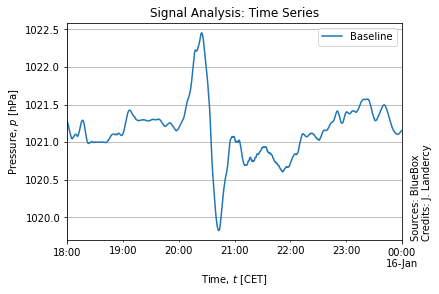

In [24]:
axe = bme280.loc["2022-01-15 18:00:00":"2022-01-16 00:00:00",["Baseline"]].plot()
axe.set_title("Signal Analysis: Time Series")
axe.set_xlabel("Time, $t$ [CET]")
axe.set_ylabel("Pressure, $p$ [hPa]")
axe.figure.text(0.92, 0.13, credits2, rotation=90)
axe.grid()

In [20]:
sel = bme280.loc["2022-01-15 18:00:00":"2022-01-16 00:00:00",["Error"]]

In [21]:
norm_p = stats.norm.fit(sel.values)
norm = stats.norm(*norm_p)
elin = np.linspace(-0.4, 0.4, 1001)

In [22]:
cauchy_p = stats.cauchy.fit(sel.values)
cauchy = stats.cauchy(*cauchy_p)

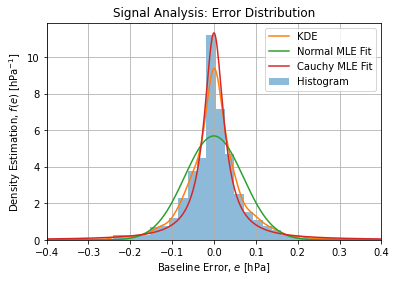

In [23]:
axe = sel.plot(kind="hist", bins=30, density=1, alpha=0.5)
sel.plot(kind="kde", ax=axe)
axe.plot(elin, norm.pdf(elin))
axe.plot(elin, cauchy.pdf(elin))
axe.set_xlim([elin.min(), elin.max()])
axe.set_title("Signal Analysis: Error Distribution")
axe.set_xlabel("Baseline Error, $e$ [hPa]")
axe.set_ylabel("Density Estimation, $f(e)$ $[\mathrm{hPa}^{-1}]$")
axe.legend(["KDE", "Normal MLE Fit", "Cauchy MLE Fit", "Histogram"])
axe.grid()